# Convolutional layers

In [16]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]

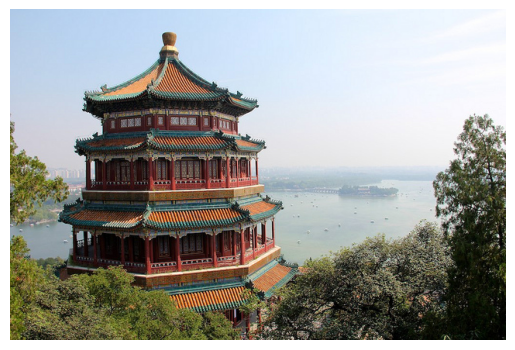

In [17]:
import matplotlib.pyplot as plt

plt.imshow(images[0])
plt.axis("off")
plt.show()

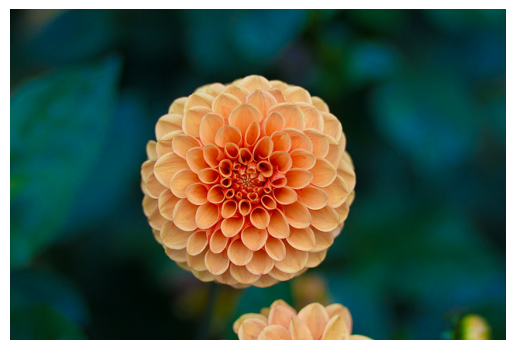

In [18]:
plt.imshow(images[1])
plt.axis("off")
plt.show()

In [20]:
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1/255)(images)

images.shape

TensorShape([2, 70, 120, 3])

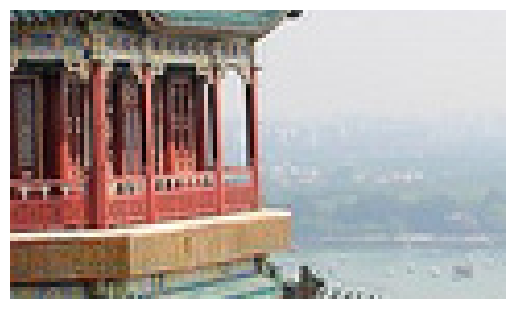

In [21]:
plt.imshow(images[0])
plt.axis("off")
plt.show()

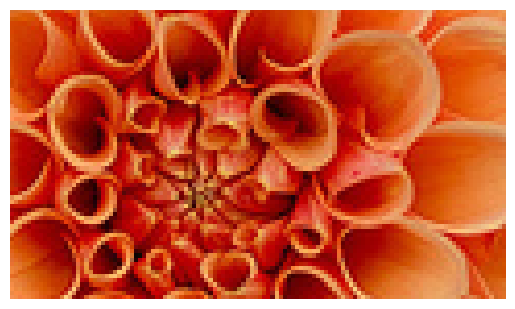

In [22]:
plt.imshow(images[1])
plt.axis("off")
plt.show()

In [29]:
# No padding by default (valid)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=(7, 7))
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 64, 114, 32])

In [30]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=(7, 7), padding="same")
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 70, 120, 32])

In [31]:
kernels, biases = conv_layer.get_weights()

In [32]:
kernels.shape

(7, 7, 3, 32)

In [33]:
biases.shape

(32,)

# Pooling layers

In [38]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
pooled_images = max_pool(images)
pooled_images.shape

TensorShape([2, 35, 60, 3])

In [40]:
pooled_fmaps = max_pool(fmaps)
pooled_fmaps.shape

TensorShape([2, 35, 60, 32])

In [44]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()
# The same as:
# global_avg_pool = tf.keras.layers.Lambda(
#     lambda X: tf.reduce_mean(X, axis=[1, 2])
# )

In [45]:
global_avg_pool(images) # avg of channels (RGB) for each image

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.2601113 , 0.10849128]], dtype=float32)>

# CNN architectures

In [51]:
# Example for MNIST

from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=(3, 3), padding="same", activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=(7, 7), input_shape=[28, 28, 1]), # 1 color channel (grayscale)
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    
    # Now the fully connected network:
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax"),
])